## 데이터마이닝 프로젝트

In [221]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

import warnings
warnings.filterwarnings('ignore')


In [222]:
# 데이터 로드

FP_PATH    = "floating_population.csv"   # 유동인구
SALES_PATH = "sales.csv"                 # 매출
STORE_PATH = "store.csv"                 # 점포


In [223]:
def read_korean_csv(path: str) -> pd.DataFrame:
    """Try common Korean encodings."""
    for enc in ("utf-8", "cp949", "euc-kr"):
        try:
            return pd.read_csv(path, encoding=enc)
        except UnicodeDecodeError:
            continue
    return pd.read_csv(path)

fp    = read_korean_csv(FP_PATH)
fp = fp[fp["기준_년분기_코드"] // 10 == 2024]
sales = read_korean_csv(SALES_PATH)
store = read_korean_csv(STORE_PATH)

print(fp.shape, sales.shape, store.shape)


(1700, 25) (67900, 53) (141001, 12)


In [224]:
f = lambda x: display(x["기준_년분기_코드"].unique())
f(fp)
f(sales)
f(store)

array([20241, 20242, 20243, 20244])

array([20241, 20242, 20243, 20244])

array([20241, 20242, 20243, 20244])

In [225]:
def get_columns(df):
    display(df.columns)
get_columns(fp)
get_columns(sales)
get_columns(store)

Index(['기준_년분기_코드', '행정동_코드', '행정동_코드_명', '총_유동인구_수', '남성_유동인구_수', '여성_유동인구_수',
       '연령대_10_유동인구_수', '연령대_20_유동인구_수', '연령대_30_유동인구_수', '연령대_40_유동인구_수',
       '연령대_50_유동인구_수', '연령대_60_이상_유동인구_수', '시간대_00_06_유동인구_수',
       '시간대_06_11_유동인구_수', '시간대_11_14_유동인구_수', '시간대_14_17_유동인구_수',
       '시간대_17_21_유동인구_수', '시간대_21_24_유동인구_수', '월요일_유동인구_수', '화요일_유동인구_수',
       '수요일_유동인구_수', '목요일_유동인구_수', '금요일_유동인구_수', '토요일_유동인구_수', '일요일_유동인구_수'],
      dtype='object')

Index(['기준_년분기_코드', '행정동_코드', '행정동_코드_명', '서비스_업종_코드', '서비스_업종_코드_명',
       '당월_매출_금액', '당월_매출_건수', '주중_매출_금액', '주말_매출_금액', '월요일_매출_금액',
       '화요일_매출_금액', '수요일_매출_금액', '목요일_매출_금액', '금요일_매출_금액', '토요일_매출_금액',
       '일요일_매출_금액', '시간대_00~06_매출_금액', '시간대_06~11_매출_금액', '시간대_11~14_매출_금액',
       '시간대_14~17_매출_금액', '시간대_17~21_매출_금액', '시간대_21~24_매출_금액', '남성_매출_금액',
       '여성_매출_금액', '연령대_10_매출_금액', '연령대_20_매출_금액', '연령대_30_매출_금액',
       '연령대_40_매출_금액', '연령대_50_매출_금액', '연령대_60_이상_매출_금액', '주중_매출_건수',
       '주말_매출_건수', '월요일_매출_건수', '화요일_매출_건수', '수요일_매출_건수', '목요일_매출_건수',
       '금요일_매출_건수', '토요일_매출_건수', '일요일_매출_건수', '시간대_건수~06_매출_건수',
       '시간대_건수~11_매출_건수', '시간대_건수~14_매출_건수', '시간대_건수~17_매출_건수',
       '시간대_건수~21_매출_건수', '시간대_건수~24_매출_건수', '남성_매출_건수', '여성_매출_건수',
       '연령대_10_매출_건수', '연령대_20_매출_건수', '연령대_30_매출_건수', '연령대_40_매출_건수',
       '연령대_50_매출_건수', '연령대_60_이상_매출_건수'],
      dtype='object')

Index(['기준_년분기_코드', '행정동_코드', '행정동_코드_명', '서비스_업종_코드', '서비스_업종_코드_명', '점포_수',
       '유사_업종_점포_수', '개업_율', '개업_점포_수', '폐업_률', '폐업_점포_수', '프랜차이즈_점포_수'],
      dtype='object')

In [226]:
#데이터 전처리
def make_numeric(df, drop_cols):
    return [c for c in df.columns if c not in drop_cols and df[c].dtype != 'object']

sales_num = make_numeric(sales, ["행정동_코드", "기준_년분기_코드"])
store_num = make_numeric(store, ["행정동_코드", "기준_년분기_코드"])

sales_agg = (sales
             .groupby(["기준_년분기_코드", "행정동_코드"])[sales_num]
             .sum()
             .reset_index())

store_agg = (store
             .groupby(["기준_년분기_코드", "행정동_코드"])[store_num]
             .median() # 0 값이 많아 median과 차이가 있는데 어떤 걸로 할지?
             .reset_index())

# merged 건들면 안됨!
merged = (fp
          .merge(sales_agg, on=["기준_년분기_코드", "행정동_코드"], how="left")
          .merge(store_agg, on=["기준_년분기_코드", "행정동_코드"], how="left"))
merged = merged.dropna(axis=0)
print("Merged:", merged.shape)


Merged: (1696, 80)


In [227]:
merged.isna().sum().sum()

0

In [228]:
# 표준화 후 PCA 분석
feature_cols = [c for c in merged.columns
                if c not in ("행정동_코드", "기준_년분기_코드") and merged[c].dtype != 'object']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(merged[feature_cols])

pca = PCA(n_components=0.95, random_state=42, svd_solver='full')
X_pca = pca.fit_transform(X_scaled)

print(f"PCA → {X_pca.shape[1]} components (cum var {pca.explained_variance_ratio_.sum():.2%})")


PCA → 8 components (cum var 95.74%)


-> 8개 주성분으로 원본 데이터의 분산 95.05% 설명 가능

In [229]:
seoul_gu_code_map = {
    '11110': '종로구',
    '11140': '중구',
    '11170': '용산구',
    '11200': '성동구',
    '11215': '광진구',
    '11230': '동대문구',
    '11260': '중랑구',
    '11290': '성북구',
    '11305': '강북구',
    '11320': '도봉구',
    '11350': '노원구',
    '11380': '은평구',
    '11410': '서대문구',
    '11440': '마포구',
    '11470': '양천구',
    '11500': '강서구',
    '11530': '구로구',
    '11545': '금천구',
    '11560': '영등포구',
    '11590': '동작구',
    '11620': '관악구',
    '11650': '서초구',
    '11680': '강남구',
    '11710': '송파구',
    '11740': '강동구'
}

import pandas as pd

# 예시 DataFrame
# merged = pd.read_csv("your_file.csv")  # 실제 사용할 때

# 행정동_코드를 문자열로 변환
merged['행정동_코드'] = merged['행정동_코드'].astype(str)

# 시군구 코드 추출 (앞 5자리)
merged['시군구코드'] = merged['행정동_코드'].str[:5]

# 자치구명 매핑
merged['자치구'] = merged['시군구코드'].map(seoul_gu_code_map)

# 결과 확인
print(merged[['행정동_코드', '시군구코드', '자치구']])

        행정동_코드  시군구코드  자치구
0     11350619  11350  노원구
1     11350621  11350  노원구
2     11350624  11350  노원구
3     11350625  11350  노원구
4     11350630  11350  노원구
...        ...    ...  ...
1695  11620585  11620  관악구
1696  11620595  11620  관악구
1697  11110515  11110  종로구
1698  11110530  11110  종로구
1699  11110540  11110  종로구

[1696 rows x 3 columns]


In [230]:
selected_df = pd.DataFrame()
selected_df["총_유동인구_수"] = merged["총_유동인구_수"]
selected_df["청년층_유동인구_비율"] = (merged["연령대_20_유동인구_수"] + merged["연령대_30_유동인구_수"])/merged["총_유동인구_수"]
selected_df["청년_매출_비율"] = (merged["연령대_20_매출_건수"] + merged["연령대_30_매출_건수"]) / merged["당월_매출_건수"]
selected_df["주말_매출_비율"] =  merged["주중_매출_건수"]/ merged["주말_매출_건수"]
selected_df["행정동_코드"] = merged["행정동_코드"]
selected_df["야간유동인구비율"] = (merged["시간대_17_21_유동인구_수"] 
                            + merged["시간대_21_24_유동인구_수"] 
                            + merged["시간대_00_06_유동인구_수"]) / merged["총_유동인구_수"]
selected_df["점포당_월매출액"] = merged["당월_매출_금액"] / merged["유사_업종_점포_수"]
selected_df["객단가"] = merged["당월_매출_금액"] / merged["당월_매출_건수"]
selected_df["개업_율"] = merged["개업_율"]
selected_df["프랜차이즈_점포_비율"] = merged["프랜차이즈_점포_수"] / merged["유사_업종_점포_수"]


# 4.1 이상치 처리
def remove_outliers(df, columns):
    df_clean = df.copy()
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    return df_clean

# 이상치가 많이 발생할 수 있는 변수들 선택
outlier_columns = ['총_유동인구_수', '청년층_유동인구_비율', '청년_매출_비율', '주말_매출_비율', '야간유동인구비율', '점포당_월매출액', '객단가', '개업_율', '프랜차이즈_점포_비율']
selected_df = remove_outliers(selected_df, outlier_columns)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(selected_df)

pca2 = PCA(n_components=2)
X_pca2 = pca2.fit_transform(X_scaled)

pca3 = PCA(n_components=3)
X_pca3 = pca3.fit_transform(X_scaled)


In [231]:
# 클러스터 로직
kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)

selected_df['cluster'] = kmeans.fit_predict(X_pca2)

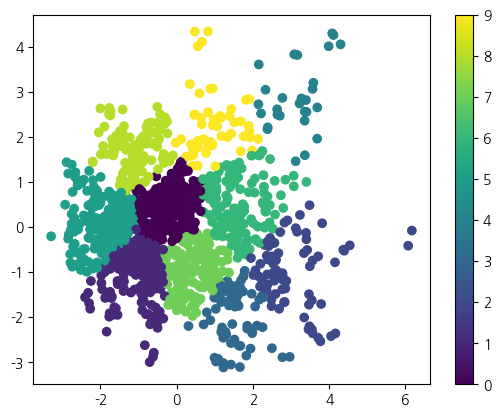

In [232]:
# 2d 시각화
plt.scatter(X_pca2[:, 0], X_pca2[:, 1], c=selected_df['cluster'], cmap='viridis')
plt.colorbar()
plt.show()


=== 클러스터별 평균 통계 ===


,총_유동인구_수,청년층_유동인구_비율,청년_매출_비율,주말_매출_비율,야간유동인구비율,점포당_월매출액,객단가,개업_율,프랜차이즈_점포_비율
cluster,,,,,,,,,
0,4819653.02,0.28,0.29,3.05,0.56,4.775723e+09,23970.16,0.0,0.0
1,4926877.52,0.27,0.30,2.86,0.58,3.310179e+09,18532.17,0.0,0.0
2,7637015.76,0.43,0.47,2.75,0.56,6.823853e+09,24033.05,0.0,0.0
3,6829389.97,0.39,0.44,2.52,0.57,4.961857e+09,18832.88,0.0,0.0
4,6348257.24,0.36,0.40,3.89,0.51,8.563297e+09,32421.92,0.0,0.0
5,3112735.65,0.24,0.25,3.23,0.58,2.774483e+09,20124.12,0.0,0.0
6,6359830.21,0.33,0.37,3.10,0.55,6.418578e+09,25867.19,0.0,0.0
7,6605318.02,0.32,0.36,2.94,0.57,4.482716e+09,20137.39,0.0,0.0
8,2970505.90,0.23,0.23,3.35,0.56,4.679664e+09,27137.72,0.0,0.0



=== 클러스터별 샘플 데이터 (원래 스케일) ===

클러스터 8의 샘플:


,총_유동인구_수,청년층_유동인구_비율,청년_매출_비율,주말_매출_비율,행정동_코드,야간유동인구비율,점포당_월매출액,객단가,개업_율,프랜차이즈_점포_비율,cluster
1189,4432186,0.215645,0.196304,2.828344,11170630,0.547606,5.529509e+09,32221.369903,0.0,0.0,8
751,4087538,0.286197,0.219466,3.713171,11290770,0.561724,2.754184e+09,22174.290148,0.0,0.0,8
1670,2990423,0.258065,0.217869,3.149823,11560670,0.561868,4.000278e+09,30750.396478,0.0,0.0,8
957,3200695,0.218656,0.212536,2.891780,11470620,0.553515,4.961678e+09,26538.087369,0.0,0.0,8
2,2991847,0.206602,0.244167,2.832564,11350624,0.568729,7.308574e+09,24238.591955,0.0,0.0,8
497,3228975,0.256961,0.213542,2.933236,11560670,0.561148,3.613730e+09,27006.426573,0.0,0.0,8
243,4308727,0.220134,0.362302,4.428834,11740515,0.586035,2.589030e+09,23275.319715,0.0,0.0,8
217,5397881,0.258534,0.242721,3.973073,11710520,0.564964,4.450245e+09,31979.381229,0.0,0.0,8
1606,3131161,0.215364,0.215548,2.947206,11470620,0.554507,4.757665e+09,25645.516913,0.0,0.0,8
1331,4933329,0.258945,0.243433,3.883779,11710520,0.567306,3.953756e+09,28451.346254,0.0,0.0,8



클러스터 5의 샘플:


,총_유동인구_수,청년층_유동인구_비율,청년_매출_비율,주말_매출_비율,행정동_코드,야간유동인구비율,점포당_월매출액,객단가,개업_율,프랜차이즈_점포_비율,cluster
467,5044395,0.219087,0.207597,3.074855,11530730,0.591173,3.573694e+09,20621.428202,0.0,0.0,5
1007,2150270,0.240576,0.288796,3.130314,11545700,0.598348,2.662804e+09,16075.325926,0.0,0.0,5
214,1195646,0.241035,0.384105,3.130465,11680740,0.566594,1.061769e+09,14764.318750,0.0,0.0,5
997,1758258,0.235157,0.302786,3.455353,11530790,0.560961,2.546812e+09,14142.526572,0.0,0.0,5
840,4465603,0.231112,0.291419,3.468901,11290620,0.587665,2.729461e+09,17832.769389,0.0,0.0,5
65,2720182,0.242590,0.294423,3.176556,11470580,0.563737,2.391454e+09,14734.118249,0.0,0.0,5
64,3771886,0.247264,0.193557,3.138430,11470570,0.587445,3.019331e+09,21308.058153,0.0,0.0,5
872,3154063,0.231916,0.252310,3.364318,11320522,0.570839,1.705328e+09,16011.355318,0.0,0.0,5
812,2626673,0.261705,0.293058,3.006368,11380632,0.573747,2.906635e+09,22929.587174,0.0,0.0,5
1560,2615860,0.249531,0.292784,3.221597,11380632,0.573341,2.850400e+09,24263.575396,0.0,0.0,5



클러스터 0의 샘플:


,총_유동인구_수,청년층_유동인구_비율,청년_매출_비율,주말_매출_비율,행정동_코드,야간유동인구비율,점포당_월매출액,객단가,개업_율,프랜차이즈_점포_비율,cluster
890,4161290,0.231458,0.250156,2.515673,11350625,0.571727,7.373069e+09,23277.082128,0.0,0.0,0
864,3948848,0.268690,0.220353,2.085714,11305645,0.573343,8.274480e+09,24102.856256,0.0,0.0,0
1510,5597172,0.273365,0.172284,2.486782,11305615,0.561683,1.048579e+10,25285.385387,0.0,0.0,0
1261,6573670,0.237303,0.294005,2.900727,11320690,0.547051,4.559889e+09,24440.360634,0.0,0.0,0
499,3933551,0.300014,0.360513,3.482389,11560690,0.556824,2.250789e+09,20144.447309,0.0,0.0,0
1127,2277930,0.254683,0.288390,3.347422,11710690,0.569397,5.015792e+09,19906.337701,0.0,0.0,0
1520,3751601,0.208715,0.207591,2.314631,11320521,0.558816,8.337114e+09,23621.332580,0.0,0.0,0
365,7376039,0.273845,0.289051,2.721098,11260620,0.570328,5.432055e+09,34457.143264,0.0,0.0,0
847,7785760,0.254310,0.297522,3.239796,11290715,0.542329,3.258923e+09,19009.156391,0.0,0.0,0
671,2902617,0.312456,0.309460,3.282377,11170700,0.562354,2.995519e+09,21916.530819,0.0,0.0,0



클러스터 7의 샘플:


,총_유동인구_수,청년층_유동인구_비율,청년_매출_비율,주말_매출_비율,행정동_코드,야간유동인구비율,점포당_월매출액,객단가,개업_율,프랜차이즈_점포_비율,cluster
785,8309845,0.323539,0.421427,4.042069,11350600,0.567148,5.419543e+09,14768.203972,0.0,0.0,7
1264,4624573,0.341792,0.391780,2.863906,11350560,0.548187,2.884474e+09,18770.759670,0.0,0.0,7
377,5624592,0.335414,0.352276,3.145454,11290610,0.561470,2.768222e+09,20567.999013,0.0,0.0,7
21,8543272,0.280531,0.311360,2.489471,11380600,0.584855,5.215997e+09,21363.756881,0.0,0.0,7
1583,5375234,0.305327,0.377346,3.293949,11440610,0.563490,4.157922e+09,20708.412478,0.0,0.0,7
449,7988451,0.315739,0.331809,2.869506,11500593,0.579962,4.013579e+09,16882.111815,0.0,0.0,7
1048,8420358,0.340109,0.390906,2.944952,11620605,0.576341,4.642561e+09,23436.995686,0.0,0.0,7
1488,5566810,0.341948,0.354466,3.087943,11290610,0.567133,2.769108e+09,19700.680076,0.0,0.0,7
946,6791343,0.306206,0.399700,2.746204,11470520,0.591447,3.666196e+09,19998.216375,0.0,0.0,7
1216,4435244,0.324655,0.358718,3.522055,11215750,0.596255,4.350260e+09,23154.048573,0.0,0.0,7



클러스터 2의 샘플:


,총_유동인구_수,청년층_유동인구_비율,청년_매출_비율,주말_매출_비율,행정동_코드,야간유동인구비율,점포당_월매출액,객단가,개업_율,프랜차이즈_점포_비율,cluster
414,4510338,0.478356,0.588419,2.416009,11440680,0.532714,7.836877e+09,29895.743971,0.0,0.0,2
1696,10849912,0.503150,0.459444,2.691038,11620595,0.585198,6.392108e+09,22786.950167,0.0,0.0,2
600,8266108,0.369319,0.432219,2.399253,11710650,0.580470,8.224881e+09,27180.964939,0.0,0.0,2
5,10659895,0.283722,0.447573,2.370129,11350640,0.550130,5.498184e+09,26087.255635,0.0,0.0,2
690,6903558,0.486773,0.467983,3.322084,11215730,0.548049,4.314307e+09,22811.429926,0.0,0.0,2
586,6314479,0.427504,0.525739,2.397576,11710562,0.569830,8.382548e+09,28597.224426,0.0,0.0,2
1541,10214213,0.281916,0.429406,2.539440,11350640,0.554427,5.872483e+09,25159.188143,0.0,0.0,2
635,9687330,0.486931,0.535619,2.593069,11110650,0.541783,6.291293e+09,18495.522216,0.0,0.0,2
1049,5390186,0.465066,0.418194,2.909441,11620615,0.583254,7.437957e+09,21209.106165,0.0,0.0,2
1276,5400796,0.471159,0.428357,2.912914,11620615,0.583778,7.333169e+09,20935.391536,0.0,0.0,2



클러스터 1의 샘플:


,총_유동인구_수,청년층_유동인구_비율,청년_매출_비율,주말_매출_비율,행정동_코드,야간유동인구비율,점포당_월매출액,객단가,개업_율,프랜차이즈_점포_비율,cluster
1542,8686008,0.207549,0.235999,2.728167,11350665,0.575791,2.332870e+09,15776.798055,0.0,0.0,1
950,4112625,0.255183,0.240175,2.263256,11470560,0.583503,4.530872e+09,20602.831688,0.0,0.0,1
1253,5243604,0.294034,0.341880,2.858223,11260630,0.574869,4.064940e+09,17355.951960,0.0,0.0,1
893,8849934,0.206847,0.238269,2.668908,11350665,0.572521,2.398096e+09,15623.607677,0.0,0.0,1
173,7125849,0.341660,0.182576,3.054856,11620745,0.578990,3.015370e+09,21158.557591,0.0,0.0,1
1502,11394994,0.239415,0.241021,3.140999,11305534,0.578302,3.880289e+09,17140.841624,0.0,0.0,1
1498,7001331,0.262231,0.333333,2.640287,11290760,0.581893,2.262181e+09,16297.737942,0.0,0.0,1
656,3909989,0.318930,0.327388,3.143860,11170510,0.578543,3.748266e+09,16551.265204,0.0,0.0,1
1014,5499685,0.312678,0.307852,2.795636,11560585,0.592417,2.635858e+09,25305.707411,0.0,0.0,1
922,1877381,0.265608,0.538447,2.198722,11410655,0.596250,2.552176e+09,14410.176625,0.0,0.0,1



클러스터 6의 샘플:


,총_유동인구_수,청년층_유동인구_비율,청년_매출_비율,주말_매출_비율,행정동_코드,야간유동인구비율,점포당_월매출액,객단가,개업_율,프랜차이즈_점포_비율,cluster
129,5523694,0.376684,0.408200,4.270315,11560610,0.509351,3.530740e+09,17941.640599,0.0,0.0,6
322,5257366,0.346198,0.470910,3.045458,11200670,0.527619,7.617295e+09,27731.951815,0.0,0.0,6
291,6006106,0.365773,0.287775,2.518213,11140670,0.539615,9.384364e+09,30438.276727,0.0,0.0,6
1682,6157335,0.395313,0.389673,4.133993,11590605,0.538027,6.716563e+09,17906.624962,0.0,0.0,6
1609,10965882,0.289114,0.330187,3.129723,11470650,0.570225,4.721533e+09,26053.102705,0.0,0.0,6
1401,3541169,0.284172,0.345441,2.885229,11140665,0.540982,8.996573e+09,28462.362168,0.0,0.0,6
771,4140358,0.270986,0.334471,3.099904,11320515,0.551017,8.679608e+09,22723.313857,0.0,0.0,6
1402,5824539,0.381708,0.296052,2.722175,11140670,0.554052,7.829944e+09,28940.441485,0.0,0.0,6
286,4126349,0.343267,0.386931,3.415922,11140625,0.540421,6.363982e+09,27918.607846,0.0,0.0,6
755,7966388,0.309747,0.287584,3.562431,11305535,0.560962,6.832940e+09,20666.531405,0.0,0.0,6



클러스터 3의 샘플:


,총_유동인구_수,청년층_유동인구_비율,청년_매출_비율,주말_매출_비율,행정동_코드,야간유동인구비율,점포당_월매출액,객단가,개업_율,프랜차이즈_점포_비율,cluster
1053,6113476,0.466861,0.293063,2.393887,11620655,0.589170,4.656151e+09,18094.100229,0.0,0.0,3
352,4691778,0.417280,0.441365,2.785423,11230730,0.568052,3.553137e+09,24684.076201,0.0,0.0,3
163,6224007,0.429618,0.393716,2.754861,11620625,0.585812,6.893731e+09,16753.162214,0.0,0.0,3
1240,8327026,0.486759,0.526917,3.002163,11230740,0.549363,3.629669e+09,12130.388205,0.0,0.0,3
18,11678663,0.327050,0.319973,2.684557,11380570,0.575643,4.401237e+09,21088.064548,0.0,0.0,3
1658,6783305,0.324753,0.472371,2.028569,11560515,0.572856,6.922327e+09,12869.691404,0.0,0.0,3
1230,11286951,0.342626,0.414901,2.236805,11230560,0.558332,4.138751e+09,19452.873548,0.0,0.0,3
1054,5096783,0.460584,0.444576,2.615031,11620665,0.592141,3.502392e+09,13173.003812,0.0,0.0,3
1277,6054479,0.431916,0.368708,2.869028,11620625,0.587378,6.925072e+09,16918.934135,0.0,0.0,3
1448,8750852,0.381709,0.479734,2.491864,11215847,0.570036,4.667175e+09,21358.609576,0.0,0.0,3



클러스터 9의 샘플:


,총_유동인구_수,청년층_유동인구_비율,청년_매출_비율,주말_매출_비율,행정동_코드,야간유동인구비율,점포당_월매출액,객단가,개업_율,프랜차이즈_점포_비율,cluster
1302,4703151,0.302742,0.415550,2.807494,11650610,0.543024,4.934391e+09,37215.017433,0.0,0.0,9
929,7511425,0.308470,0.318658,4.271474,11440555,0.533069,4.880316e+09,24837.112040,0.0,0.0,9
1581,5726242,0.266089,0.276789,4.180745,11440590,0.550186,8.660045e+09,32194.173670,0.0,0.0,9
830,7577861,0.309350,0.327130,4.489789,11440555,0.535264,4.760074e+09,24314.454514,0.0,0.0,9
1422,4982456,0.326603,0.314322,3.462216,11200540,0.534146,5.727645e+09,27257.366109,0.0,0.0,9
186,4135989,0.229405,0.284859,2.965886,11650590,0.552072,6.516066e+09,30375.275578,0.0,0.0,9
255,6011262,0.277162,0.341261,3.149172,11740640,0.540857,4.064790e+09,38975.085634,0.0,0.0,9
34,4080711,0.262279,0.216439,3.307928,11410640,0.561582,1.166965e+10,24153.404881,0.0,0.0,9
1269,3734624,0.248188,0.220203,2.706652,11350611,0.538114,9.587872e+09,25618.292811,0.0,0.0,9
190,6560061,0.277546,0.293640,4.111430,11650621,0.541999,5.623993e+09,34306.882035,0.0,0.0,9



클러스터 4의 샘플:


,총_유동인구_수,청년층_유동인구_비율,청년_매출_비율,주말_매출_비율,행정동_코드,야간유동인구비율,점포당_월매출액,객단가,개업_율,프랜차이즈_점포_비율,cluster
545,6695495,0.374026,0.378299,3.574316,11650560,0.533602,9.238165e+09,37896.363682,0.0,0.0,4
491,9256968,0.339930,0.394246,4.614007,11560605,0.495993,1.021050e+10,33482.444354,0.0,0.0,4
187,4361990,0.319062,0.348138,4.248730,11650600,0.536045,9.863192e+09,33881.722406,0.0,0.0,4
180,6387215,0.324840,0.424795,3.352344,11650540,0.508892,9.238780e+09,37828.589975,0.0,0.0,4
1015,9272180,0.339883,0.385484,4.543856,11560605,0.493654,1.038912e+10,35568.425593,0.0,0.0,4
1079,5583784,0.356836,0.365157,4.314672,11650652,0.502962,6.447505e+09,24875.231866,0.0,0.0,4
488,6883302,0.406495,0.341520,3.643524,11560550,0.512722,8.490769e+09,34815.205339,0.0,0.0,4
1090,10904498,0.289174,0.298819,2.978444,11680630,0.493290,1.180763e+10,27513.568069,0.0,0.0,4
493,4936770,0.404652,0.423868,4.317173,11560620,0.526812,5.564439e+09,29718.200491,0.0,0.0,4
1296,6803734,0.368970,0.381419,3.596050,11650560,0.534084,9.042261e+09,38361.224833,0.0,0.0,4



=== 클러스터별 구 분포 (상위 3개) ===

클러스터 8의 주요 구:
- 양천구: 20개 행정동
- 강동구: 14개 행정동
- 송파구: 13개 행정동

클러스터 5의 주요 구:
- 노원구: 21개 행정동
- 양천구: 20개 행정동
- 구로구: 16개 행정동

클러스터 0의 주요 구:
- 강서구: 28개 행정동
- 송파구: 17개 행정동
- 강동구: 17개 행정동

클러스터 7의 주요 구:
- 중랑구: 21개 행정동
- 광진구: 17개 행정동
- 성북구: 15개 행정동

클러스터 2의 주요 구:
- 관악구: 12개 행정동
- 송파구: 11개 행정동
- 마포구: 8개 행정동

클러스터 1의 주요 구:
- 중랑구: 22개 행정동
- 은평구: 21개 행정동
- 노원구: 17개 행정동

클러스터 6의 주요 구:
- 송파구: 21개 행정동
- 동작구: 18개 행정동
- 성동구: 17개 행정동

클러스터 3의 주요 구:
- 관악구: 24개 행정동
- 광진구: 10개 행정동
- 동대문구: 10개 행정동

클러스터 9의 주요 구:
- 마포구: 11개 행정동
- 송파구: 7개 행정동
- 서초구: 6개 행정동

클러스터 4의 주요 구:
- 서초구: 10개 행정동
- 영등포구: 7개 행정동
- 강서구: 4개 행정동


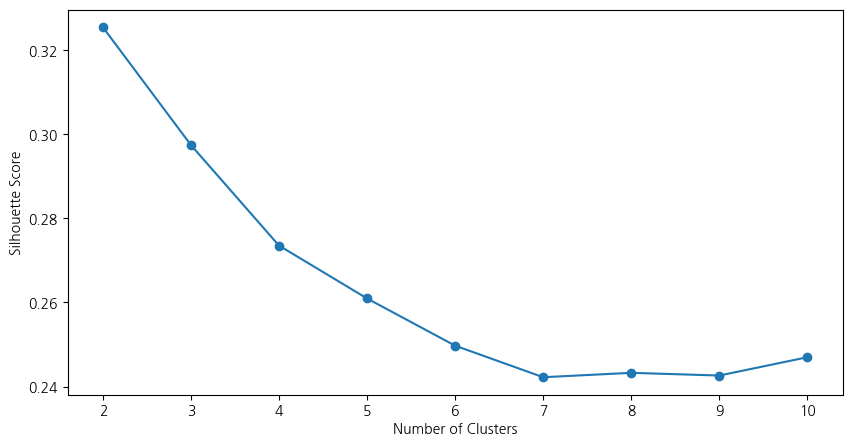

최적의 클러스터 수: 2


In [233]:
# 클러스터별 통계 분석
cluster_stats = selected_df.groupby('cluster').agg({
    "총_유동인구_수": 'mean',
    "청년층_유동인구_비율": 'mean',
    "청년_매출_비율": 'mean',
    "주말_매출_비율": 'mean',
    "야간유동인구비율": 'mean',
    "점포당_월매출액": 'mean',
    "객단가": 'mean',
    "개업_율": 'mean',
    "프랜차이즈_점포_비율": 'mean',
}).round(2)

# 각 클러스터별 샘플 데이터 확인 (각 클러스터에서 3개씩)
cluster_samples = {}
for cluster in selected_df['cluster'].unique():
    cluster_samples[cluster] = selected_df[selected_df['cluster'] == cluster].sample(10)

# 결과 출력
print("=== 클러스터별 평균 통계 ===")
display(cluster_stats)

print("\n=== 클러스터별 샘플 데이터 (원래 스케일) ===")
for cluster, samples in cluster_samples.items():
    print(f"\n클러스터 {cluster}의 샘플:")
    display(samples)

# 각 클러스터별 구 분포 분석
print("\n=== 클러스터별 구 분포 (상위 3개) ===")
for cluster in selected_df['cluster'].unique():
    cluster_data = selected_df[selected_df['cluster'] == cluster]
    # 행정동 코드의 앞 5자리가 구 코드
    gu_counts = cluster_data['행정동_코드'].astype(str).str[:5].value_counts()
    
    print(f"\n클러스터 {cluster}의 주요 구:")
    for gu_code, count in gu_counts.head(3).items():
        gu_name = seoul_gu_code_map.get(gu_code, '알 수 없음')
        print(f"- {gu_name}: {count}개 행정동")

#  실루엣 계수
from sklearn.metrics import silhouette_score

silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca3)
    labels = kmeans.labels_
    score = silhouette_score(X_pca3, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(10, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

# 최적의 클러스터 수 찾기
best_k = silhouette_scores.index(max(silhouette_scores)) + 2
print(f"최적의 클러스터 수: {best_k}")


=== 클러스터별 구 분포 (상위 3개) ===

클러스터 8의 주요 구:
- 양천구: 20개 행정동
- 강동구: 14개 행정동
- 송파구: 13개 행정동

클러스터 5의 주요 구:
- 노원구: 21개 행정동
- 양천구: 20개 행정동
- 구로구: 16개 행정동

클러스터 0의 주요 구:
- 강서구: 28개 행정동
- 송파구: 17개 행정동
- 강동구: 17개 행정동

클러스터 7의 주요 구:
- 중랑구: 21개 행정동
- 광진구: 17개 행정동
- 성북구: 15개 행정동

클러스터 2의 주요 구:
- 관악구: 12개 행정동
- 송파구: 11개 행정동
- 마포구: 8개 행정동

클러스터 1의 주요 구:
- 중랑구: 22개 행정동
- 은평구: 21개 행정동
- 노원구: 17개 행정동

클러스터 6의 주요 구:
- 송파구: 21개 행정동
- 동작구: 18개 행정동
- 성동구: 17개 행정동

클러스터 3의 주요 구:
- 관악구: 24개 행정동
- 광진구: 10개 행정동
- 동대문구: 10개 행정동

클러스터 9의 주요 구:
- 마포구: 11개 행정동
- 송파구: 7개 행정동
- 서초구: 6개 행정동

클러스터 4의 주요 구:
- 서초구: 10개 행정동
- 영등포구: 7개 행정동
- 강서구: 4개 행정동


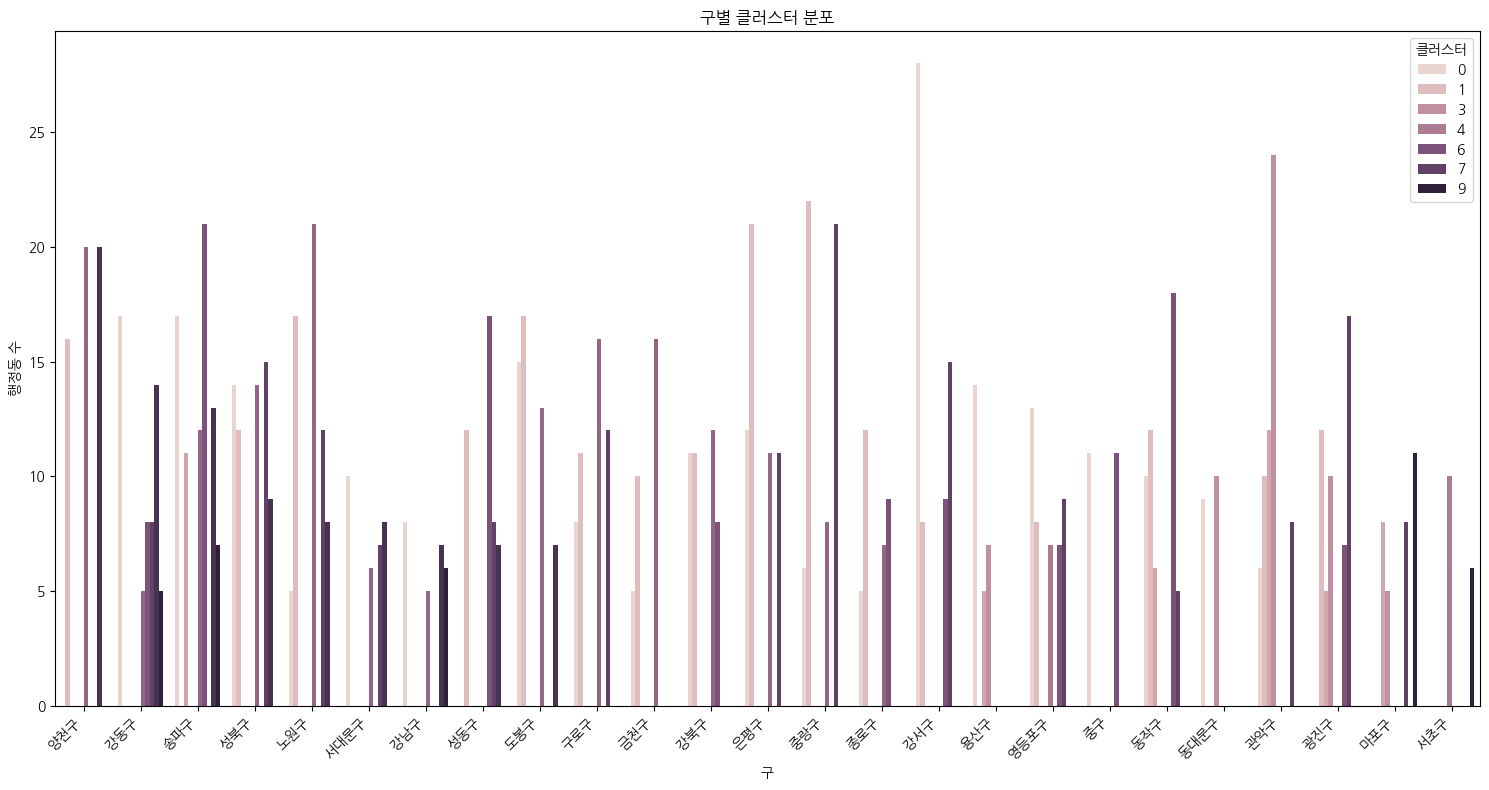

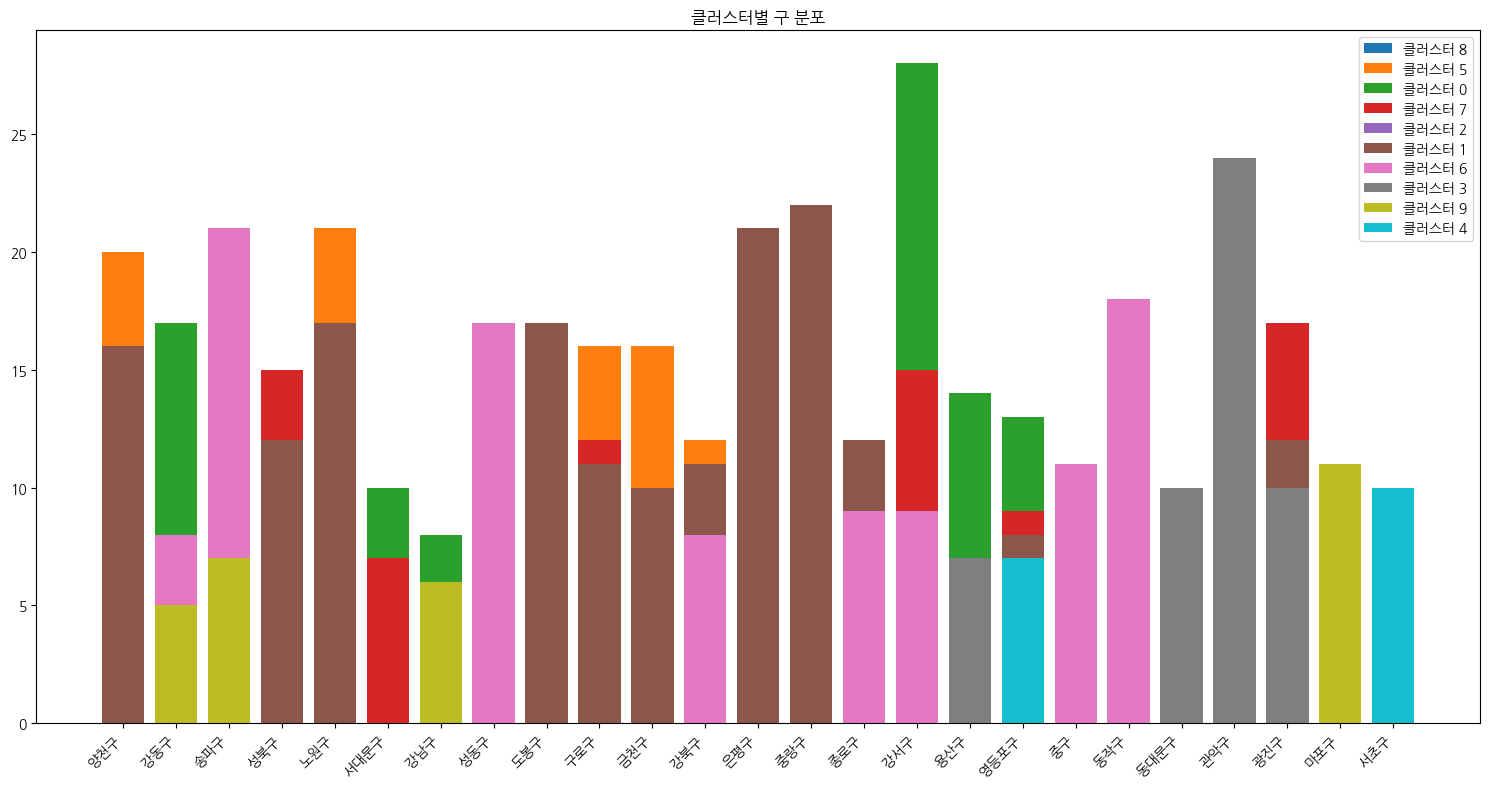

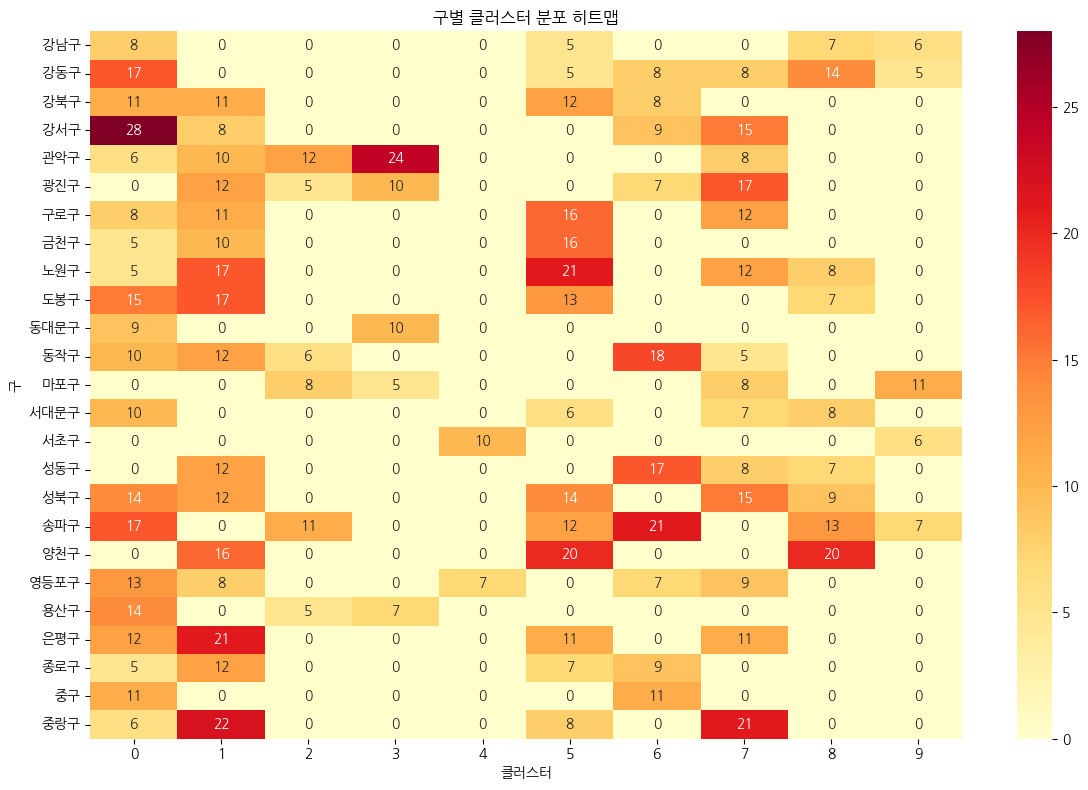

In [234]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Nanum Gothic'
plt.rcParams['axes.unicode_minus'] = False
import pandas as pd


# 클러스터별 구 분포 분석
print("\n=== 클러스터별 구 분포 (상위 3개) ===")
for cluster in selected_df['cluster'].unique():
    cluster_data = selected_df[selected_df['cluster'] == cluster]
    # 행정동 코드의 앞 5자리가 구 코드
    gu_counts = cluster_data['행정동_코드'].astype(str).str[:5].value_counts()
    
    print(f"\n클러스터 {cluster}의 주요 구:")
    for gu_code, count in gu_counts.head(3).items():
        gu_name = seoul_gu_code_map.get(gu_code, '알 수 없음')
        print(f"- {gu_name}: {count}개 행정동")

# 각 클러스터별 구 분포 분석 및 필터링
cluster_gu_counts = {}
for cluster in selected_df['cluster'].unique():
    cluster_data = selected_df[selected_df['cluster'] == cluster]
    gu_counts = cluster_data['행정동_코드'].astype(str).str[:5].value_counts()
    
    # 최소 5개 이상인 구만 선택
    significant_gu = gu_counts[gu_counts >= 5]
    cluster_gu_counts[cluster] = significant_gu

# 각 구별 클러스터 분포 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 구별 클러스터 분포 데이터 생성
gu_cluster_data = []
for cluster, gu_counts in cluster_gu_counts.items():
    for gu_code, count in gu_counts.items():
        gu_name = seoul_gu_code_map.get(gu_code, '알 수 없음')
        gu_cluster_data.append({
            '구': gu_name,
            '클러스터': cluster,
            '행정동 수': count
        })

gu_cluster_df = pd.DataFrame(gu_cluster_data)

# 시각화
plt.figure(figsize=(15, 8))
sns.barplot(data=gu_cluster_df, x='구', y='행정동 수', hue='클러스터')
plt.xticks(rotation=45, ha='right')
plt.title('구별 클러스터 분포')
plt.tight_layout()
plt.show()

# 각 클러스터별 주요 구 시각화
plt.figure(figsize=(15, 8))
for cluster in selected_df['cluster'].unique():
    cluster_data = gu_cluster_df[gu_cluster_df['클러스터'] == cluster]
    plt.bar(cluster_data['구'], cluster_data['행정동 수'], label=f'클러스터 {cluster}')

plt.xticks(rotation=45, ha='right')
plt.title('클러스터별 구 분포')
plt.legend()
plt.tight_layout()
plt.show()

# 히트맵으로 시각화
pivot_df = gu_cluster_df.pivot(index='구', columns='클러스터', values='행정동 수').fillna(0)
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_df, annot=True, cmap='YlOrRd', fmt='.0f')
plt.title('구별 클러스터 분포 히트맵')
plt.tight_layout()
plt.show()

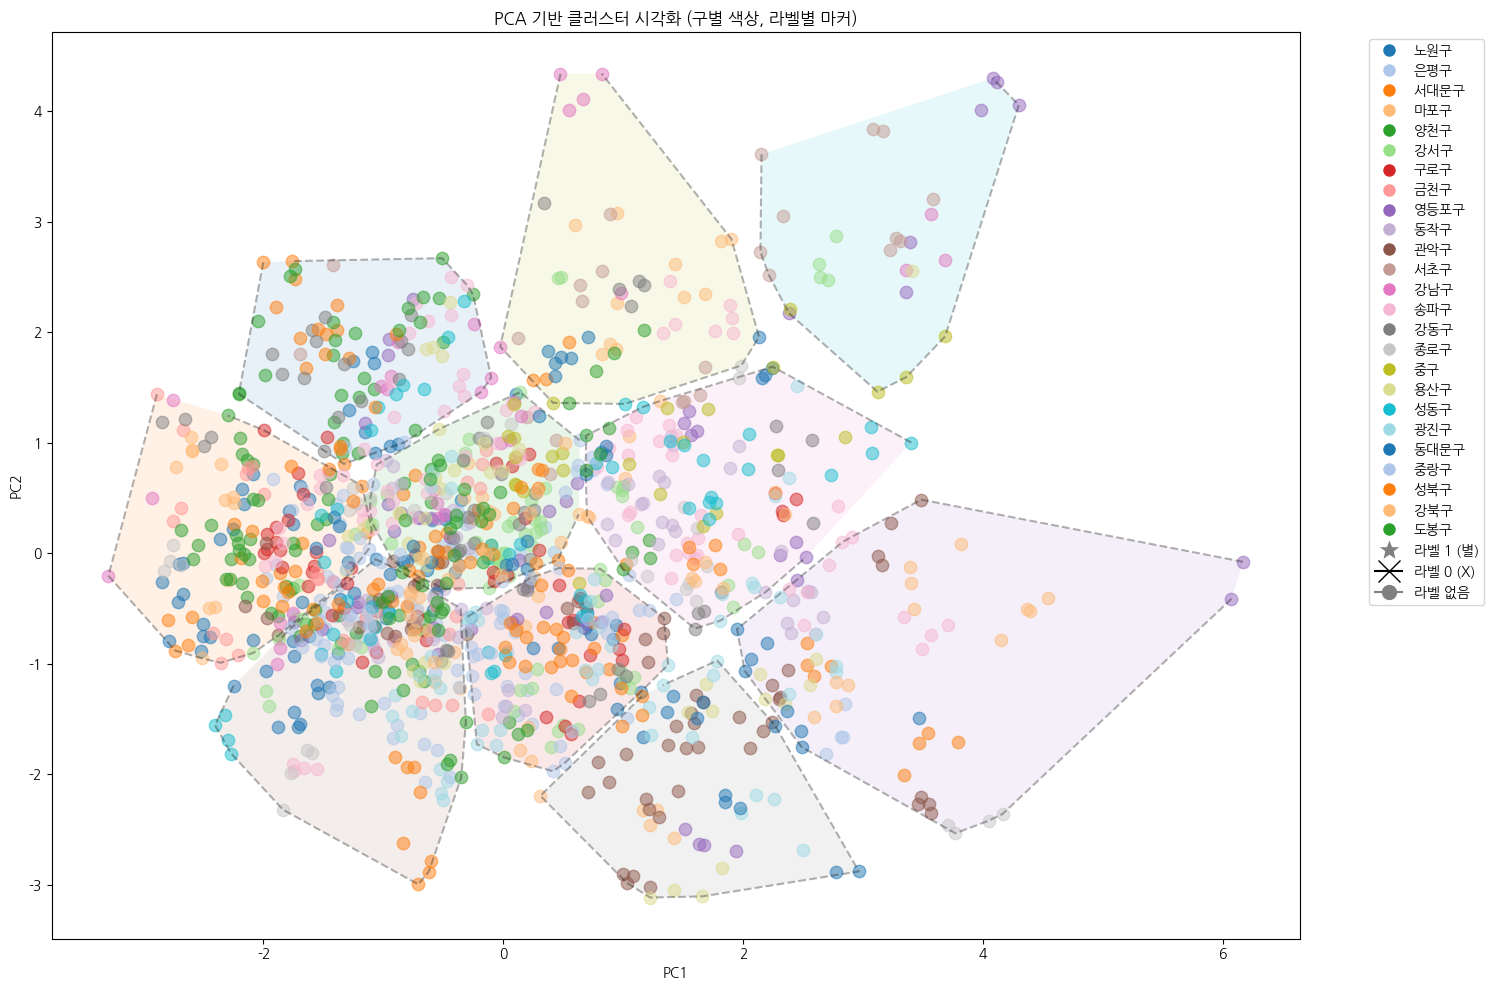

In [235]:
import pandas as pd
from scipy.spatial import ConvexHull

# label.xlsx에서 라벨 정보 읽기
label_df = pd.read_excel('label.xlsx')

label_map = dict(zip(label_df['행정동_코드'], label_df['라벨']))

# selected_df에 라벨 컬럼 추가 (없으면 NaN)
selected_df['라벨'] = selected_df['행정동_코드'].map(label_map)

plt.figure(figsize=(15, 10))

unique_gu_codes = selected_df['행정동_코드'].astype(str).str[:5].unique()
gu_colors = {gu_code: plt.cm.tab20(i % 20) for i, gu_code in enumerate(unique_gu_codes)}

for cluster in selected_df['cluster'].unique():
    cluster_mask = selected_df['cluster'] == cluster
    cluster_points = X_pca2[cluster_mask]
    if len(cluster_points) > 2:
        hull = ConvexHull(cluster_points)
        plt.plot(cluster_points[hull.vertices, 0], cluster_points[hull.vertices, 1], 'k--', alpha=0.3)
        plt.fill(cluster_points[hull.vertices, 0], cluster_points[hull.vertices, 1], alpha=0.1)
    
    for gu_code in unique_gu_codes:
        gu_mask = selected_df['행정동_코드'].astype(str).str[:5] == gu_code
        combined_mask = cluster_mask & gu_mask
        # 라벨별로 마커 다르게
        star_mask = combined_mask & (selected_df['라벨'] == 1)
        x_mask = combined_mask & (selected_df['라벨'] == 0)
        none_mask = combined_mask & (selected_df['라벨'].isna())
        if star_mask.any():
            plt.scatter(
                X_pca2[star_mask, 0],
                X_pca2[star_mask, 1],
                c=[gu_colors[gu_code]],
                marker='*',
                s=600,                # 훨씬 크게!
                edgecolor='black',
                linewidths=2.5,       # 두꺼운 테두리
                alpha=1.0,
                zorder=10,
                label=None
            )
        if x_mask.any():
            plt.scatter(
                X_pca2[x_mask, 0],
                X_pca2[x_mask, 1],
                c=[gu_colors[gu_code]],
                marker='x',
                s=400,                # 훨씬 크게!
                edgecolor='black',
                linewidths=4,         # 두꺼운 테두리
                alpha=1.0,
                zorder=9,
                label=None
            )
        if none_mask.any():
            plt.scatter(
                X_pca2[none_mask, 0],
                X_pca2[none_mask, 1],
                c=[gu_colors[gu_code]],
                marker='o',
                s=80,
                alpha=0.5,
                zorder=1,
                label=None
            )

# 범례 추가 (구별 색상)
handles = [plt.Line2D([0], [0], marker='o', color='w', 
                     markerfacecolor=gu_colors[gu_code], 
                     markersize=10, 
                     label=seoul_gu_code_map.get(gu_code, "알 수 없음"))
          for gu_code in unique_gu_codes]

# 마커별 범례 추가
handles += [
    plt.Line2D([0], [0], marker='*', color='w', markerfacecolor='gray', markersize=18, label='라벨 1 (별)'),
    plt.Line2D([0], [0], marker='x', color='black', markerfacecolor='black', markersize=16, label='라벨 0 (X)'),
    plt.Line2D([0], [0], marker='o', color='gray', markerfacecolor='gray', markersize=10, label='라벨 없음')
]

plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('PCA 기반 클러스터 시각화 (구별 색상, 라벨별 마커)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()

In [236]:
print(selected_df['라벨'].value_counts(dropna=False))
print(selected_df[['행정동_코드', '라벨']].head(10))
# 두 데이터프레임의 행정동_코드 타입을 맞추세요!
selected_df['행정동_코드'] = selected_df['행정동_코드'].astype(str)
label_df['행정동_코드'] = label_df['행정동_코드'].astype(str)

# 다시 라벨 매핑
selected_df['라벨'] = selected_df['행정동_코드'].map(dict(zip(label_df['행정동_코드'], label_df['라벨'])))
print(selected_df['라벨'].value_counts(dropna=False))
labeled_df = selected_df[selected_df['라벨'].isin([0, 1])]
print(len(labeled_df))
print(labeled_df[['행정동_코드', '라벨']].head())

# 라벨이 있는 데이터만 추출
labeled_df = selected_df[selected_df['라벨'].isin([0, 1])]

# 각 라벨별로 클러스터 분포 출력
for label_value in [0.0, 1.0]:
    print(f"\n라벨 {label_value}인 데이터의 클러스터 분포:")
    label_cluster_counts = labeled_df[labeled_df['라벨'] == label_value]['cluster'].value_counts().sort_index()
    for cluster, count in label_cluster_counts.items():
        print(f"  클러스터 {cluster}: {count}개")

라벨
NaN    1309
Name: count, dtype: int64
     행정동_코드  라벨
0  11350619 NaN
1  11350621 NaN
2  11350624 NaN
3  11350625 NaN
4  11350630 NaN
5  11350640 NaN
6  11350665 NaN
7  11350670 NaN
8  11350695 NaN
9  11350700 NaN
라벨
NaN    820
0.0    388
1.0    101
Name: count, dtype: int64
489
      행정동_코드   라벨
0   11350619  1.0
6   11350665  0.0
8   11350695  0.0
14  11380530  0.0
16  11380552  0.0

라벨 0.0인 데이터의 클러스터 분포:
  클러스터 0: 65개
  클러스터 1: 80개
  클러스터 2: 15개
  클러스터 3: 27개
  클러스터 4: 12개
  클러스터 5: 55개
  클러스터 6: 54개
  클러스터 7: 47개
  클러스터 8: 21개
  클러스터 9: 12개

라벨 1.0인 데이터의 클러스터 분포:
  클러스터 0: 18개
  클러스터 1: 15개
  클러스터 2: 14개
  클러스터 3: 12개
  클러스터 4: 4개
  클러스터 5: 7개
  클러스터 6: 14개
  클러스터 7: 8개
  클러스터 8: 7개
  클러스터 9: 2개


In [237]:
# 클러스터별 1.0, 0.0 개수와 비율 출력
print("클러스터별 1.0/0.0 비율 (1.0 개수 / 0.0 개수):")
for cluster in sorted(labeled_df['cluster'].unique()):
    cluster_data = labeled_df[labeled_df['cluster'] == cluster]
    count_1 = (cluster_data['라벨'] == 1.0).sum()
    count_0 = (cluster_data['라벨'] == 0.0).sum()
    ratio = count_1 / count_0 if count_0 > 0 else float('inf')
    print(f"클러스터 {cluster}: 1.0 = {count_1}, 0.0 = {count_0}, 비율(1.0/0.0) = {ratio:.2f}")

클러스터별 1.0/0.0 비율 (1.0 개수 / 0.0 개수):
클러스터 0: 1.0 = 18, 0.0 = 65, 비율(1.0/0.0) = 0.28
클러스터 1: 1.0 = 15, 0.0 = 80, 비율(1.0/0.0) = 0.19
클러스터 2: 1.0 = 14, 0.0 = 15, 비율(1.0/0.0) = 0.93
클러스터 3: 1.0 = 12, 0.0 = 27, 비율(1.0/0.0) = 0.44
클러스터 4: 1.0 = 4, 0.0 = 12, 비율(1.0/0.0) = 0.33
클러스터 5: 1.0 = 7, 0.0 = 55, 비율(1.0/0.0) = 0.13
클러스터 6: 1.0 = 14, 0.0 = 54, 비율(1.0/0.0) = 0.26
클러스터 7: 1.0 = 8, 0.0 = 47, 비율(1.0/0.0) = 0.17
클러스터 8: 1.0 = 7, 0.0 = 21, 비율(1.0/0.0) = 0.33
클러스터 9: 1.0 = 2, 0.0 = 12, 비율(1.0/0.0) = 0.17


In [238]:
#클러스터2 데이터 추출
print(selected_df[selected_df['cluster'] == 2]['행정동_코드'].value_counts())

행정동_코드
11350640    4
11710562    4
11305635    4
11290575    4
11260590    4
11215730    4
11410615    4
11110650    4
11710650    4
11170555    4
11620725    4
11620615    4
11620595    4
11590620    4
11440680    4
11440600    4
11230720    3
11710580    3
11560535    2
11590530    2
11170660    1
11215850    1
11230710    1
11560560    1
Name: count, dtype: int64
